In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE, R2, MBE, F1_metric
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Split on test, train, validation

In [4]:
train_img_list = []
test_img_list = []
val_img_list = []

train_list_split = ['0_0', '0_1', '0_2',
               '1_0', '1_2',
               '2_0', '2_1', '2_3', '2_4', '2_5',
               '3_1', '3_2', '3_3',
               '4_1', '4_3', '4_4', '4_5',
               '5_1', '5_2', '5_3', '5_4',
               '6_0', '6_1', '6_2', '6_4',
               '7_0', '7_1', '7_2', '7_3', '7_4']
val_list_split = ['1_1', '2_2', '4_2', '6_3']

# krasnoborsk
for folder in os.listdir('/home/user/data/krasnoborsk/world_view/'):
    if 'tif' in folder or 'xml' in folder or folder == 'lines':
        continue
    for file_name in os.listdir('/home/user/data/krasnoborsk/world_view/{}'.format(folder)):
        tmp_ind = file_name.split('_')[0]+'_'+file_name.split('_')[1]
        if tmp_ind in train_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in train_img_list:
            train_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]
        elif tmp_ind in val_list_split and '/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind) not in val_img_list \
            and folder == '0':
            val_img_list += ['/home/user/data/krasnoborsk/world_view/{}/{}'.format(folder, tmp_ind)]

# Novoshinsk
dse_pathechs = ['0_0', '0_1', '0_2',
               '1_0', '1_1', '1_2', '1_3',
               '2_0', '2_1', '2_2', '2_3', '2_4', 
               '3_0', '3_1', '3_2', '3_3', '3_4',
               '4_0', '4_1', '4_3', '4_4',
               '5_3', '5_4',
               '6_2', '6_3', '6_4',
               '7_2', '7_3', '7_4',
               '8_2', '8_3', '8_4']

for file_ind in [0, 1, 7, 9]: 
    for patch_ind in dse_pathechs:
        i, j = patch_ind.split('_')
        if patch_ind +'_channel_0.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)) \
            or patch_ind +'_class_606.tif' not in os.listdir('/home/user/data/krasnoborsk/Novoshinsk/{}'.format(file_ind)):
            continue
        if patch_ind in ['1_1', '2_2', '4_4']:
            test_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]
        else:
            train_img_list += ['/home/user/data/krasnoborsk/Novoshinsk/{}/{}'.format(file_ind, patch_ind)]


## New model

In [5]:
batch_size=20 
num_channels=4

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = False              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = True     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided
generator.arctic_dem = True
generator.arctic_stat = {'min':125, 'max':250}

generator.lidar_coef = 5           # parameter for height resolution downsampling
generator.lidar_resolution = 1     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.clip_value = 40.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif']

In [6]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [8]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

nb_name = 'regr_rgb_pan_wv_arctic.ipynb'

save_file = nb_name.split('.')[0] + '.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

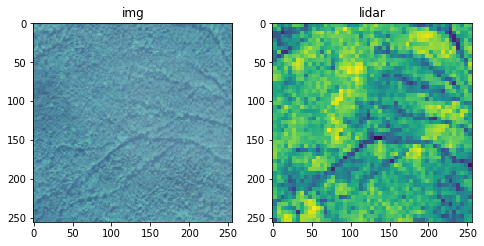

In [9]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'lidar')

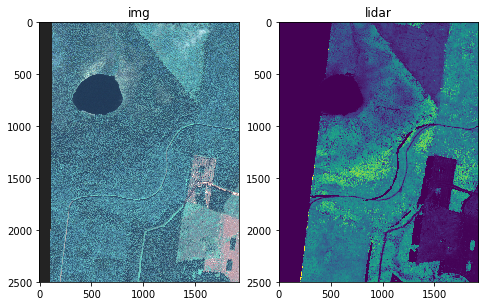

In [17]:
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set model

In [7]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [8]:
model_name = 'regr_rgb_pan_wv_arctic'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [12]:
history=model.fit_generator(generator.train_gen(),epochs=25, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/25
200/200 [==============================] - 172s 861ms/step - loss: 0.1511 - rmse: 0.1511 - val_loss: 0.1479 - val_rmse: 0.1479

Epoch 00001: val_loss improved from inf to 0.14794, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_wv_arctic.h5

Epoch 00001: val_loss improved from inf to 0.14794, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_wv_arctic.hdf5
Epoch 2/25
200/200 [==============================] - 139s 696ms/step - loss: 0.1320 - rmse: 0.1320 - val_loss: 0.1473 - val_rmse: 0.1473

Epoch 00002: val_loss improved from 0.14794 to 0.14730, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_wv_arctic.h5

Epoch 00002: val_loss improved from 0.14794 to 0.14730, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_rgb_pan_wv_arctic.hdf5
Epoch 3/25
200/200 [==============================] - 140s 698ms

In [9]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Evaluation

In [17]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[0])
generator.augm  = True

Text(0.5,1,'lidar')

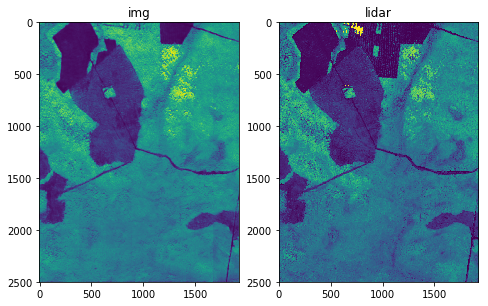

In [18]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [19]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 4.562
MAE 2.721


In [10]:
generator.augm  = False
average_rmse = 0
average_mae = 0
average_r2 = 0
average_mean_bias = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_r2 = R2(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mean_bias = MBE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    average_r2 += cur_r2
    average_mean_bias += cur_mean_bias
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae,  ' r2: ', cur_r2,  ' mbe: ', cur_mean_bias, )
generator.augm  = True

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))
print('Average R2: ', round(average_r2 / len(val_img_list), 3))
print('Average mean bias: ', round(average_mean_bias / len(val_img_list), 3))

0 rmse:  4.562  mae:  2.721  r2:  0.58  mbe:  -0.07949202759905624
1 rmse:  3.427  mae:  2.574  r2:  0.646  mbe:  -1.0184384856769078
2 rmse:  4.52  mae:  3.307  r2:  0.713  mbe:  0.13651765281373124
3 rmse:  4.221  mae:  3.269  r2:  0.429  mbe:  -1.849245030957712
~~~~~~~~~~~~~~~~
Average RMSE:  4.182
Average MAE:  2.968
Average R2:  0.592
Average mean bias:  -0.703


In [11]:
num_cl = 4
F1_score = np.zeros((num_cl))
class_names=['0-4', '4-10', '10-20', '>20']
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    
    prediction *= generator.clip_value
    full_mask *= generator.clip_value

    pred = np.zeros((1, prediction.shape[0], prediction.shape[1], num_cl))
    mask = np.zeros((1, full_mask.shape[0], full_mask.shape[1], num_cl)) 

    pred[:,:,:,0] = np.where(prediction[:,:,0]>0, 1, 0) * np.where(prediction[:,:,0]<4, 1, 0)
    mask[:,:,:,0] = np.where(full_mask[:,:,0]>0, 1, 0) * np.where(full_mask[:,:,0]<4, 1, 0)

    pred[:,:,:,1] = np.where(prediction[:,:,0]>=4, 1, 0) * np.where(prediction[:,:,0]<10, 1, 0)
    mask[:,:,:,1] = np.where(full_mask[:,:,0]>=4, 1, 0) * np.where(full_mask[:,:,0]<10, 1, 0)

    pred[:,:,:,2] = np.where(prediction[:,:,0]>=10, 1, 0) * np.where(prediction[:,:,0]<20, 1, 0)
    mask[:,:,:,2] = np.where(full_mask[:,:,0]>=10, 1, 0) * np.where(full_mask[:,:,0]<20, 1, 0)

    pred[:,:,:,3] = np.where(prediction[:,:,0]>=20, 1, 0)
    mask[:,:,:,3] = np.where(full_mask[:,:,0]>=20, 1, 0)

    F1_score += F1_metric(pred, mask, num_cl = num_cl, class_names=[])
    

0 : precision  0.849  recall  0.34  f1  0.486
 
1 : precision  0.464  recall  0.659  f1  0.545
 
2 : precision  0.723  recall  0.918  f1  0.809
 
3 : precision  0.691  recall  0.007  f1  0.013
 
0 : precision  0.676  recall  0.565  f1  0.615
 
1 : precision  0.607  recall  0.564  f1  0.584
 
2 : precision  0.835  recall  0.845  f1  0.84
 
3 : precision  0.328  recall  0.374  f1  0.349
 
0 : precision  0.79  recall  0.662  f1  0.72
 
1 : precision  0.281  recall  0.215  f1  0.244
 
2 : precision  0.513  recall  0.809  f1  0.627
 
3 : precision  0.558  recall  0.224  f1  0.32
 
0 : precision  0.22  recall  0.442  f1  0.294
 
1 : precision  0.04  recall  0.597  f1  0.076
 
2 : precision  0.647  recall  0.411  f1  0.502
 
3 : precision  0.365  recall  0.005  f1  0.009
 


In [12]:
print(F1_score / len(val_img_list))
print(np.sum(F1_score / len(val_img_list))/num_cl)

[0.5286921  0.36209536 0.69463338 0.17286715]
0.4395719984330272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


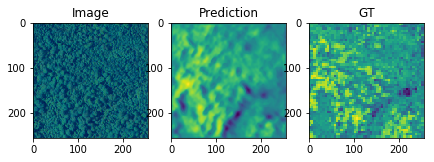

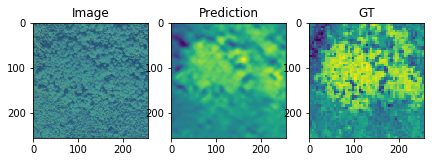

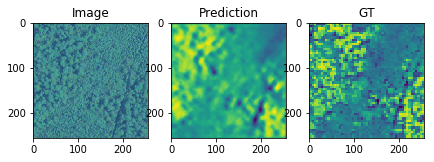

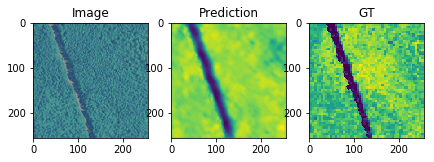

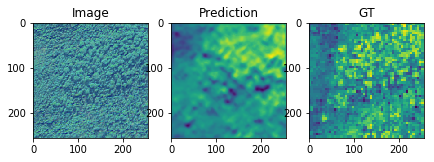

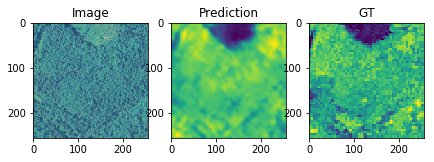

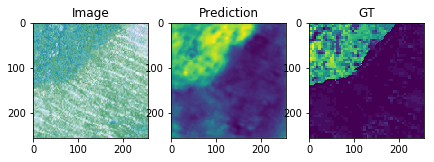

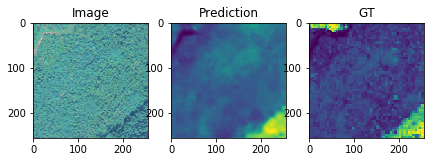

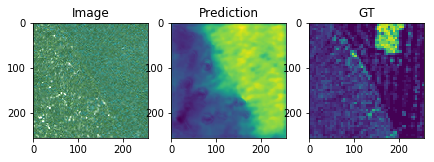

In [56]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

for num in range(1, 10):
    fig = plt.figure(figsize=(7, 7))
    
    a = fig.add_subplot(1, 3, 1)
    a.set_title('Image')
    imgplot = plt.imshow(img[num,:,:,:3])
    
    cl=0
    a = fig.add_subplot(1, 3, 2)
    a.set_title('Prediction')
    imgplot = plt.imshow(pred[num, :, :,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 3, 3)
    a.set_title('GT')
    imgplot = plt.imshow(mask[num, :, :,0])

## Save prediction

In [ ]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [39]:
val_img_list

['/home/user/data/krasnoborsk/world_view/0/6_3',
 '/home/user/data/krasnoborsk/world_view/0/2_2',
 '/home/user/data/krasnoborsk/world_view/0/4_2',
 '/home/user/data/krasnoborsk/world_view/0/1_1']

In [11]:
generator.augm = False
recon, mask = generator.pred_img(model, '/home/user/data/krasnoborsk/world_view/0/6_3')
generator.full_img = True
#img, _ = generator.get_img_mask_array('/home/user/data/mapbox_our/17_4/17_4')
#generator.full_img = False

In [18]:
save_pred(img_to_save=recon[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img='/home/user/data/krasnoborsk/world_view/0/6_3_channel_0.tif', crs=4326)
tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')

2045 1248 (2498, 1918)


(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f5ce3ca6d30>)

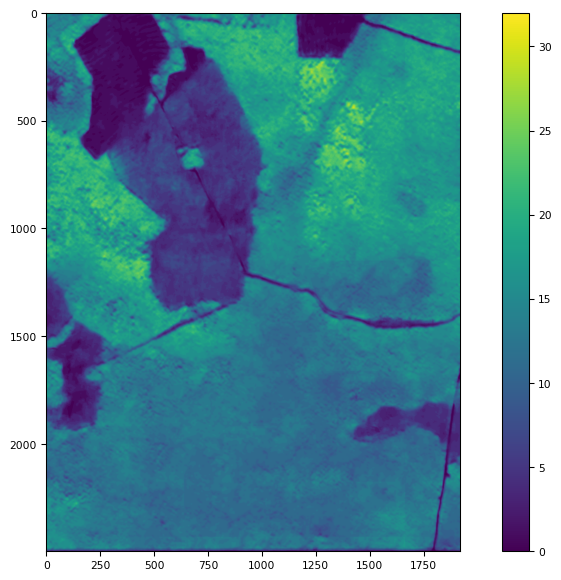

In [19]:
tmp = tiff.imread('../images/tmp.tif')
tiff.imshow(tmp)

# Inference without markup

In [14]:
batch_size=20 
num_channels=3

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = True              # just geometric rotation is applied
generator.color_aug_prob = 1       # add color augm

generator.sharpen_flag = True     # flag to switch pansharpaning
generator.forest_mask = True       # add forest mask if it is provided

generator.lidar_coef = 0           # parameter for height resolution downsampling
generator.lidar_resolution = 2     # resolution of height data
generator.target_resolution = 1    # target resolution both for height and imagery
generator.clip_value = 40.         # the greatest height value 

generator.classifier_mode = 'regression'
generator.channels_list = ['channel_0.tif', 'channel_1.tif', 'channel_2.tif']

generator.write_gdalinfo_file()

In [24]:
generator.augm = False
recon, _ = generator.pred_img(model, '/home/user/data/krasnoborsk/world_view/0/6_3', inference=True)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f261ce70320>)

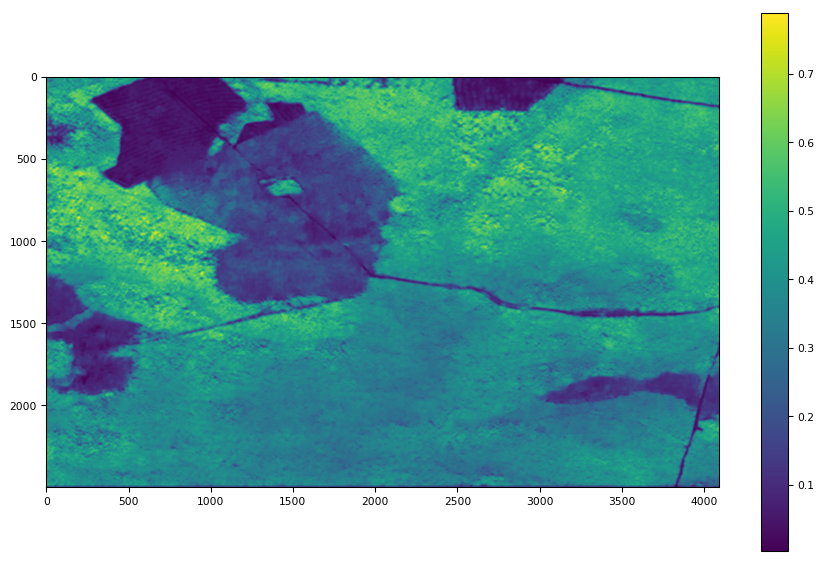

In [27]:
tiff.imshow(recon)

In [30]:
generator.inference

False

Text(0.5,1,'lidar')

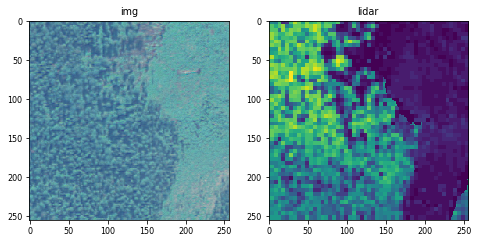

In [44]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(img_tmp[:,:,:3])
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')